<a href="https://colab.research.google.com/github/mateusrossatto/pyspark/blob/main/semantix_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepara o ambiente para rodar o Spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!wget https://repo1.maven.org/maven2/org/apache/spark/spark-sql-kafka-0-10_2.12/3.0.3/spark-sql-kafka-0-10_2.12-3.0.3.jar
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!rm spark-3.0.3-bin-hadoop2.7.tgz
!mkdir data
!pip install -q findspark
!pip install kafka-python

--2021-11-07 23:02:28--  https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220400553 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.3-bin-hadoop2.7.tgz’

spark-3.0.3-bin-had 100%[===================>] 210.19M   164MB/s    in 1.3s    

2021-11-07 23:02:30 (164 MB/s) - ‘spark-3.0.3-bin-hadoop2.7.tgz’ saved [220400553/220400553]

--2021-11-07 23:02:30--  https://repo1.maven.org/maven2/org/apache/spark/spark-sql-kafka-0-10_2.12/3.0.3/spark-sql-kafka-0-10_2.12-3.0.3.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350879 (343K) [application/java-archive]
Saving to: ‘spark-sql-kafka-

In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /content/spark-sql-kafka-0-10_2.12-3.0.3.jar pyspark-shell'

findspark.init()
findspark.find()

'/content/spark-3.0.3-bin-hadoop2.7'

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession \
       .builder \
       .appName('app-semantix') \
       .getOrCreate()

# Upload dos arquivos csv

Fazer o upload dos arquivos csv para o diretório data criado na preparação do ambiente.

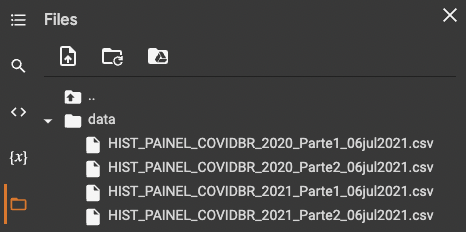






# Executa a leitura dos arquivos para um dataframe

In [ ]:
df = spark.read.csv('/content/data/*.csv', header=True, inferSchema=True, sep=';')
df.show()

# Salva dataset como tabela particionada por município

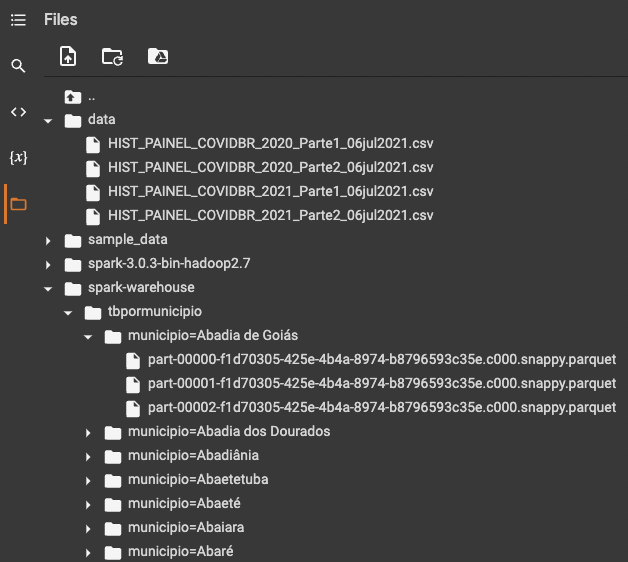

In [ ]:
# Salva tabela particionada
df.write.partitionBy('municipio').mode('overwrite').saveAsTable('tbpormunicipio')

# Leitura da tabela com filtro de município para validar os dados salvos
df_tabela_por_municipio = spark.sql('SELECT * FROM tbpormunicipio WHERE municipio="Porto Alegre"')
df_tabela_por_municipio.show()

# Cria visualizações

### Primeira visualização
*   Casos recuperados
*   Em acompanhamento

### Segunda visualização
*   Casos confirmados
*   Acumulado
*   Casos novos
*   Incidências

### Terceira visualização
*   Óbitos acumulados
*   Casos novos
*   Letalidade
*   Mortalidade




In [6]:
# Cria a primeira visualização
df_primeira_visualizacao = spark.read.table('tbpormunicipio')\
  .select('Recuperadosnovos', 'emAcompanhamentoNovos')\
  .filter('Recuperadosnovos IS NOT NULL')\
  .filter('emAcompanhamentoNovos IS NOT NULL')\
  .withColumnRenamed('Recuperadosnovos', 'casos_recuperados')\
  .withColumnRenamed('emAcompanhamentoNovos', 'em_acompanhamento')\
  .orderBy(desc('data')).limit(1)

# Salva a primeira visualização como CSV para análise
df_primeira_visualizacao.write.format('csv').mode('overwrite')\
  .option('header', 'true')\
  .save('/content/data/csv/primeira_visualizacao')

# Exibe a primeira visualização
df_primeira_visualizacao.show()

+-----------------+-----------------+
|casos_recuperados|em_acompanhamento|
+-----------------+-----------------+
|         17262646|          1065477|
+-----------------+-----------------+



In [7]:
# Cria a segunda visualização
df_segunda_visualizacao = spark.read.table('tbpormunicipio')\
  .select('casosAcumulado', 'casosNovos', 'populacaoTCU2019')\
  .filter('regiao = "Brasil"')\
  .orderBy(desc('data'))\
  .withColumn('casosAcumulado', col('casosAcumulado').cast(DecimalType(20, 0)))\
  .withColumn('incidencia', 
              (col('casosAcumulado') / col('populacaoTCU2019') * 100000)
              .cast(DecimalType(10,1)))\
  .withColumnRenamed('casosAcumulado', 'acumulado')\
  .withColumnRenamed('casosNovos', 'casos_novos')\
  .select('acumulado', 'casos_novos', 'incidencia')\
  .limit(1)

# Salva a segunda visualização como CSV para análise
df_segunda_visualizacao.write.format('csv').mode('overwrite')\
  .option('header', 'true')\
  .save('/content/data/csv/segunda_visualizacao')

# Exibe a terceira visualização
df_segunda_visualizacao.show()

+---------+-----------+----------+
|acumulado|casos_novos|incidencia|
+---------+-----------+----------+
| 18855015|      62504|    8972.3|
+---------+-----------+----------+



In [8]:
# Cria a terceira visualização
df_terceira_visualizacao = spark.read.table('tbpormunicipio')\
  .select('obitosAcumulado', 'casosAcumulado', 'populacaoTCU2019', 'obitosNovos')\
  .filter('regiao = "Brasil"')\
  .orderBy(desc('data'))\
  .withColumn('letalidade %', 
              (col('obitosAcumulado') / col('casosAcumulado') * 100)
              .cast(DecimalType(10,1)))\
  .withColumn('mortalidade', 
              (col('obitosAcumulado') / col('populacaoTCU2019') * 100000)
              .cast(DecimalType(10,1)))\
  .withColumnRenamed('obitosAcumulado', 'obitos_acumulados')\
  .withColumnRenamed('obitosNovos', 'casos_novos')\
  .select('obitos_acumulados', 'casos_novos', 'letalidade %', 'mortalidade')\
  .limit(1)

# Salva a terceira visualização como CSV para análise
df_terceira_visualizacao.write.format('csv').mode('overwrite')\
  .option('header', 'true')\
  .save('/content/data/csv/terceira_visualizacao')

# Exibe a terceira visualização
df_terceira_visualizacao.show()

+-----------------+-----------+------------+-----------+
|obitos_acumulados|casos_novos|letalidade %|mortalidade|
+-----------------+-----------+------------+-----------+
|           526892|       1780|         2.8|      250.7|
+-----------------+-----------+------------+-----------+



# Salva visualizações

In [9]:
# Salva a primeira visualicação como tabela Hive
df_primeira_visualizacao.write.mode('overwrite').saveAsTable('tbprimeiravisualizacao')
print(spark.catalog.listTables())

# Leitura da tabela criada para validar o salvamento
spark.sql('SELECT * FROM tbprimeiravisualizacao').show()

[Table(name='tbpormunicipio', database='default', description=None, tableType='MANAGED', isTemporary=False), Table(name='tbprimeiravisualizacao', database='default', description=None, tableType='MANAGED', isTemporary=False)]
+-----------------+-----------------+
|casos_recuperados|em_acompanhamento|
+-----------------+-----------------+
|         17262646|          1065477|
+-----------------+-----------------+



In [10]:
# Salva a segunda visualização com formato parquet e compressão snappy
df_segunda_visualizacao.write.mode('overwrite')\
  .option('compression', 'snappy')\
  .parquet('/content/data/parquet/segunda_visualizacao')

# Leitura do arquivo parquet para validar o salvamento
spark.read.parquet('/content/data/parquet/segunda_visualizacao').show()

+---------+-----------+----------+
|acumulado|casos_novos|incidencia|
+---------+-----------+----------+
| 18855015|      62504|    8972.3|
+---------+-----------+----------+



## Criação da instância e tópico do kafka


### Preparação do ambiente kafka

In [11]:
!curl -sSOL https://archive.apache.org/dist/kafka/2.7.0/kafka_2.13-2.7.0.tgz
!tar -xzf kafka_2.13-2.7.0.tgz
!rm kafka_2.13-2.7.0.tgz

In [12]:
!./kafka_2.13-2.7.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-2.7.0/config/zookeeper.properties
!./kafka_2.13-2.7.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-2.7.0/config/server.properties
!echo "Aguarda inicialicação dos serviços"
!sleep 10

Aguarda inicialicação dos serviços


In [ ]:
!ps -ef | grep kafka

In [14]:
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic semantix-project

Created topic semantix-project.


In [15]:
!./kafka_2.13-2.7.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic semantix-project

Topic: semantix-project	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: semantix-project	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


In [16]:
 !./kafka_2.13-2.7.0/bin/kafka-topics.sh --version

2.7.0 (Commit:448719dc99a19793)


In [ ]:
#https://spark.apache.org/docs/3.0.3/streaming-kafka-0-10-integration.html
!/content/spark-3.0.3-bin-hadoop2.7/bin/spark-shell\
  --packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.3

In [37]:
kafka_topic_name = "semantix-project"
kafka_bootstrap_servers = 'localhost:9092'

In [30]:
!./kafka_2.13-2.7.0/bin/kafka-console-consumer.sh\
  --bootstrap-server localhost:9092\
  --topic semantix-project\
  --from-beginning

Hello
Processed a total of 1 messages


In [29]:
!./kafka_2.13-2.7.0/bin/kafka-console-producer.sh\
  --broker-list localhost:9092\
  --topic semantix-project

>Hello
>